<a href="https://colab.research.google.com/github/HeesangJin/ml_study/blob/main/cifar10_cnn_resnet_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'available device : %s' % device)
torch.manual_seed(888)
if device == 'cuda':
  torch.cuda.manual_seed_all(888)

available device : cuda


In [ ]:
!nvidia-smi

Sat Jul 16 09:12:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Image Preparation

In [ ]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'total training samples : {batch_size * len(trainloader)}')
print(f'total test samples : {batch_size * len(testloader)}')

Files already downloaded and verified
Files already downloaded and verified
total training samples : 50000
total test samples : 10000


 bird  deer  bird  bird 


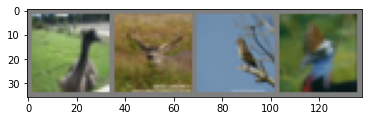

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s ' % classes[labels[j]] for j in range(4)))

CNN

In [ ]:
class myNN(torch.nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        # N, C, H, W
        # intput = (N, 3,  32, 32)
        # Conv  -> (N, 32, 32, 32)
        # Relu  -> (N, 32, 32, 32)
        # Pool  -> (N, 32, 16, 16)
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # N, C, H, W
        # input = (N, 32, 16, 16)
        # Conv -> (N, 64, 16, 16)
        # Relu -> (N, 64, 16, 16)
        # Pool -> (N, 64, 8,  8 )
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Final FC: 8*8*64 -> 10 outputs
        self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
model = myNN().to(device)

In [ ]:
learning_rate = 0.001
training_epochs = 2

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(trainloader)
print("Training Start!")

for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() / total_batch
        
    print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, running_loss))
print("Training Finished !")

Training Start!
[Epoch:    1] loss = 1.25356113
[Epoch:    2] loss = 0.983239477
Training Finished !


GroundTruth:   frog  frog  ship horse


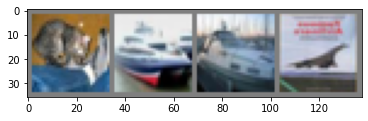

In [ ]:
dataiter = iter(testloader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images = images.to(device)
outputs = model(images)

In [ ]:
print(outputs.shape)
_, predicted = torch.max(outputs, 1)
print('predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

torch.Size([4, 10])
predicted:    cat  ship  ship  ship


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct/total))

Accuracy of the network on the 10000 test images: 66 %


In [ ]:
class_correct = list(0. for i in(range(10)))
class_total = list(0. for i in(range(10)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 58 %
Accuracy of   car: 82 %
Accuracy of  bird: 51 %
Accuracy of   cat: 62 %
Accuracy of  deer: 55 %
Accuracy of   dog: 58 %
Accuracy of  frog: 76 %
Accuracy of horse: 64 %
Accuracy of  ship: 84 %
Accuracy of truck: 73 %


ResNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

In [ ]:
from torch.functional import norm
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride=1, downsample=None, 
               norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d

    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x) # 여기서 conv 설정에 따라서 H, W 가 반으로 줄음. 그땐 downsample 이 true
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x) # identity도 H, W 똑같이 줄여줌
    # identity랑 out이랑 더하려면 C, H, W 가 똑같아야 하는데
    # BasicBlock에서 C는 건들지 않았음
    # H, W는 첫번째 cov3x3에서 stride에 따라 반으로 줄 수 있음. 아마 3,2,1 (stride = 2, padding = 1)
    # O = (I - K + 2P) / S + 1
    # O = (32 - 3 + 2*1) / 2 + 1
    #   = 31 / 2 + 1 = 16 
    # O = (32 - 5 + 4) / 2 + 1
    #   = 31 / 2 + 1 = 16
    # ImageSize 반으로 주는 CNN 조합 (3,2,1), (5,2,2), (7,2,3)
    # ImageSize 그대로 되는 CNN 조합 (3,1,1), (5,1,2), (7,1,3)

    # out 은 첫번째 conv3x3에서 W, H가 반으로 줄어들었음
    # identity는 downsameple에서 W, H를 반으로 줄였음
    out += identity
    out = self.relu(out)

    return out

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None,
               norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self.conv1 = conv1x1(inplanes, planes)
    self.bn1 = norm_layer(planes)

    self.conv2 = conv3x3(planes, planes, stride) # 여기서 identity의 W, H를 1/2로 줄임
    self.bn2 = norm_layer(planes)

    self.conv3 = conv1x1(planes, planes * self.expansion) # 여기서 channel 수를 expansion배 만큼 확장
    self.bn3 = norm_layer(planes * self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample # 여기서 identity의 W, H를 1/2로 줄임 -> 그래야 out + identity 가능하므로
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=10, norm_layer=None):
    super(ResNet, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.inplanes = 64 # 0번째 레이어(stem)를 지났을 때의 채널 크기
    self.stem = nn.Sequential(
        nn.Conv2d(3, self.inplanes, kernel_size=7, stride=1, padding=3, 
                  bias=False),
        nn.ReLU(inplace=True)
    )
    # [stem] C: 3 -> 64, Resolution: 32 -> 32

    self.stage2 = self._make_layer(block, 64, layers[0], stride=1) # resnet 네트워크 크기에 따라서 layer별 block 개수가 정해져있음 (논문 참조)
    # [stage2] C: 64 -> 64, Resolution: 32 -> 32
    self.stage3 = self._make_layer(block, 128, layers[1], stride=2)
    # [stage3] C: 64 -> 128, Resolution: 32 -> 16
    self.stage4 = self._make_layer(block, 256, layers[2], stride=2)
    # [stage4] C: 128 -> 256, Resolution: 16 -> 8
    self.stage5 = self._make_layer(block, 512, layers[3], stride=1)
    # [stage4] C: 256 -> 512, Resolution: 8 -> 8
    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # 채널 수는 냅두고 Resolution만 1x1로 줄여서 압축
    self.fc = nn.Linear(512 * block.expansion, num_classes) # BottlenekBlock이면 x expansion 해줘야 함 (논문 참고)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, planes, blocks, stride=1):
    # 블록 종류, out channel size, 블록 개수, CNN stride
    norm_layer = self._norm_layer
    downsample = None

    # downsample을 사용하는 경우 (아래 둘중 하나라도 만족하면 사용)
    # 1) stride가 1이 아닌 경우 -> CNN을 통해서 resolution을 반으로 줄인다는 뜻이므로 identity의 resolution을 줄여야 함
    # 2) input #C 가 output #C 와 다른 경우 -> 채널을 확장한다는 뜻이므로 identity의 채널도 확장해야 함
    # 그니까 결국 downsmaple은 identity의 채널 수와 해상도를 CNN을 거친 x와 맞춰주는거임

    # in_planes, mid_planes, out_planes로 나눠서 생각해야 함. 이 코드상으로는 
    # in_planes, plance,     planes * expansion 으로 구현되어 있음 
    # bottlenek 블록에서는 채널 수가 줄었다가 다시 복구되는 구조임
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride),
          norm_layer(planes * block.expansion),
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
    self.inplanes = planes * block.expansion 
    # 첫번째 블록에서 channel size, W, H 가 바뀌는데 같은 블록이 반복되므로 그대로 유지됨
    # 그래서 첫번쨰 블록 이후에만 inplanes 를 업데이트 해주고 (2번째 부터는 어차피 똑같으므로)
    # 두번째 블록부터는 stride, downsample도 사용안함 -> channel size, W, H가 똑같이 유지되므로
    for _ in range(1, blocks): # 첫번째 블록은 빼고
      layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.stem(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.stage5(x)

    x = self.avgpool(x)
    x = torch.flatten(x, start_dim=1) # B, C, H, W. # Batch 빼고 다 펴줌
    x = self.fc(x)

    return x

def _resnet(block, layers):
  model = ResNet(block, layers)
  return model

In [ ]:
def resnet11():
    return _resnet( BasicBlock, [1, 1, 1, 1])

def resnet18():
    return _resnet( BasicBlock, [2, 2, 2, 2])

def resnet34():
    return _resnet( BasicBlock, [3, 4, 6, 3])

def resnet50():
    return _resnet( Bottleneck, [3, 4, 6, 3])

def resnet101():
    return _resnet( Bottleneck, [3, 4, 23, 3])

In [ ]:
input_temp = torch.randn(1, 3, 32, 32) # 랜덤 이미지 1개
model = resnet50()
print(model)

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (stage2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (co

In [ ]:
def compute_params(model):
  return format(np.sum([p.numel() for p in model.parameters()]).item(), ",")

print(compute_params(model)) # resnet 모델의 총 파라미터 개수

23,528,394


In [ ]:
def do_train(model, trainloader, init_lr=0.1, training_epochs=10, step=3):
  model = model.to(device)

  criterion = torch.nn.CrossEntropyLoss().to(device) # Softmax 내장되어 있음
  optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
  if step == 0:
    pass
  else:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=0.1) 
    # 10번 epoch 돌리면서, 3 step마다 lr을 10%씩 곱해서 learning함

  print("Traning start!")

  for epoch in range(training_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # set gradients to zero

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 2000 == 1999:
        print('[%d, %5d] lr: %.6f loss: %.3f' %
              (epoch + 1, i + 1, lr_scheduler.get_last_lr()[0], running_loss / 2000))
        running_loss = 0.0 # 2000번 반복마다의 running_loss 평균값을 구함

    lr_scheduler.step() # 1 epoch 끝나면 step값 업데이트  
  
  print("Training finished!")
    


In [ ]:
model = resnet11()
do_train(model, trainloader, init_lr=0.01, training_epochs=10, step=3)

Traning start!
[1,  2000] lr: 0.010000 loss: 2.121
[1,  4000] lr: 0.010000 loss: 1.878
[1,  6000] lr: 0.010000 loss: 1.762
[1,  8000] lr: 0.010000 loss: 1.658
[1, 10000] lr: 0.010000 loss: 1.543
[1, 12000] lr: 0.010000 loss: 1.465
[2,  2000] lr: 0.010000 loss: 1.360
[2,  4000] lr: 0.010000 loss: 1.295
[2,  6000] lr: 0.010000 loss: 1.231
[2,  8000] lr: 0.010000 loss: 1.194
[2, 10000] lr: 0.010000 loss: 1.123
[2, 12000] lr: 0.010000 loss: 1.064
[3,  2000] lr: 0.010000 loss: 0.993
[3,  4000] lr: 0.010000 loss: 0.967
[3,  6000] lr: 0.010000 loss: 0.945
[3,  8000] lr: 0.010000 loss: 0.945
[3, 10000] lr: 0.010000 loss: 0.879
[3, 12000] lr: 0.010000 loss: 0.885
[4,  2000] lr: 0.001000 loss: 0.703
[4,  4000] lr: 0.001000 loss: 0.667
[4,  6000] lr: 0.001000 loss: 0.645
[4,  8000] lr: 0.001000 loss: 0.641
[4, 10000] lr: 0.001000 loss: 0.637
[4, 12000] lr: 0.001000 loss: 0.644
[5,  2000] lr: 0.001000 loss: 0.610
[5,  4000] lr: 0.001000 loss: 0.589
[5,  6000] lr: 0.001000 loss: 0.599
[5,  8000] lr

In [ ]:
def do_validate(model, testloader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct/total))

In [ ]:
do_validate(model, testloader)

Accuracy of the network on the 10000 test images: 78 %


VoVNet

In [ ]:
def conv3x3_bn_relu(in_planes, out_planes, stride=1, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_planes)
  )